# Install Dependencies

In [ ]:
!pip install -U -q \
  git+https://github.com/huggingface/trl.git \
  git+https://github.com/huggingface/accelerate.git \
  git+https://github.com/huggingface/transformers.git \
  transformers datasets peft qwen-vl-utils wandb python-dotenv

# Installing bitsandbytes with correct versioning
!pip install "bitsandbytes>=0.37.0"

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -U packaging

In [ ]:
!pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121 flash-attn --no-build-isolation liger-kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB

In [ ]:
from dotenv import load_dotenv, dotenv_values

load_dotenv()
secrets = dotenv_values(".env")

HF_TOKEN = secrets["HF_TOKEN"]
WANDB_API_KEY = secrets["WANDB_API_KEY"]

In [ ]:
from huggingface_hub import notebook_login

notebook_login(token=HF_TOKEN)

# System Prompt

In [ ]:
autofill_prompt="""You're given the rules of a fantasy Trading Card Game, and are issued to autofill card data based on already provided values.

# Rules

Outline:
This fantasy Trading Card Game has an immersive and energetic theme, with heroes fighting for victory by summoning minions and casting spells.

The game is designed for 2 players.
Before the game they construct:
- A main deck of 30 cards with at most 2 copies of each card
- Each card in a main deck must be either a "Minion" or "Spell"
- A stage deck of 5 cards with at most 1 copy of each
- Each card in a stage deck must have a "Stage" "type"

The board has several components:
- Game board, one side for each players
- Main deck for each player
- Stage deck for each player
- GY (Graveyard) zone for each player
- One coin for a player with first initiative
- Two coins for a player with second initiative

At the start of the game, the following actions happen in the respective order:
1. Initiative is decided by coin flip and coins are distributed accordingly
2. Each player shuffles their decks and reveal one card from their Stage deck
3. Each player draws 5 cards from their deck
4. First turn starts

Important note:
Each Stage card in a deck represents 5 "health" of a respective player, meaning each player starts with 20 "health".

Each turn proceeds as follows:
1. Draw Phase: Each player draws a card from their main deck.
2. Set Phase: Each player in any order/concurrently sets cards facedown from their hand to their side of the game board until each has set the number of cards, equal to the number of open "Stage" cards on the field. (e.g. only 2 cards can be played the first turn)
3. Reveal Phase:
3.1 A player with first initiative (one coin) reveals one of their facedown cards and can either activate the effects of that card or discard that card and draw 2 cards.
If they choose to activate the effects, apply, according to the "type" of a card:
- "Minion": pay the "cost", summon it and then activate its "On Play" effect if it has any
- "Spell": pay the "cost", activate the spell, move it to the GY zone.
**Note**: card effects can only interact with revealed cards on the board, not facedown cards.
3.2 Next player proceeds in the same way, and then the player with first initiative (going back to 3.1)
3.3 When no more cards can be revealed, next Phase takes place
4. Battle Phase: Starting with a player with initiative, that player can either attack or skip the attack.
If they choose to attack, they should choose their minion and attack a player (the stage deck) or opponent's tapped minion by tapping that attacking minion.
Next player proceeds in the same way and battle advances until both players skip their bettle turn.
5. End Phase: The turn ends, the player with 2 coins hands one coin to the other player (changing initiative) and move to 1.

Important note:
When a player loses Health cards, for each, they reveal cards from the top of their stage deck until they reveal a card, they can pay the cost for (e.g. Free Stage, Sacrifice a LvL1 Stage).

Card Patterns:

Cards have 3 types:
- "Minion": Has "description", "level", "cost", "attack", "health", "description", "class"
- "Spell": Has "description", "cost", "description", "class", other fields are ""
- "Stage" Has "description", "description", "class", other fields are ""

General structure:
{{
  "class": "",
  "type": "",
  "description": "",
  "level": "",
  "cost": "",
  "description": "",
  "attack": "",
  "health": "",
}}

Popular mechanics:
- Draw
- Search
- Summon a minion from hand/GY/deck,
- Sacrifice
- Discard
- Tap a minion
- Resummon
- Destroy
- Deal damage
- Negate (e.g. When opponent activates a card, you can tap this to negate it this turn)
- Counter
- On Play/Death
- Shields (e.g. Gain 1 Shield, Shield 1, Shield 2...)
- Equip a minion/spell
- Double Strike
- Immune
- On Attack
- Equip (e.g. Equip: +5/+5)

Important note:
Don't limit yourself to these keywords, if you have new ideas that fit well into the game, feel free to use them.

Blue color identity:
- Tapping minions
- Returning minions to their owner's hands
- Drawing cards
- Negating/Countering
- Summoning minions for free
- Synergy with a number of cards in your hand
- Reducing Attack (e.g. Give a minion -3 Attack this turn)
- Equiping for free

Purple color identity:
- Sacrificing minions
- Discarding cards
- Destroying minions
- Death triggers (e.g. Trigger minion's Death)
- Milling cards (e.g. Mill 3 cards)
- Making opponent draw cards (e.g. Each Hero draws 3 cards, For each card in opponent's hand ...)
- Effects when another minion dies

# Notes

- Cards have a structured format
- "description", "cost", "description" are text fields
- "class" can be any one of {{"Blue", "Purple"}},
- "type" can be any one of {{"Minion", "Spell", "Stage"}}
- "health", "attack", "level" are integers. If they are already provided, they shouldn't be modified
- You can use keywords "On Play:" and "Death:"
- Make image and text consistent, so the generated text is coherent with the image
- This game doesn't have any additional assets/tokens except 3 coins
- Don't form any infinite loops with a Card
- Don't design card effects that can affect themselves (destroy/return to hand) unless explicitly intended.
- Card effects should not give permanent stat modifications or require tracking numbers between turns, since this is a physical card game without tokens or counters (except 3 coins).

# Examples

{examples}

# Important

- Draw inspiration for other card games (MTG, Hearthstone, Digimon, Pokemon).
- Fit in 10-20 words per "description".
- Card text needs to be self-synergistic, and not just a combination of mechanics, there needs to be coherence.
- Be creative and nontrivial.
- Make this card unique and legendary in terms of "description", not stats
- Don't memorize the examples above, create unique and creative card

# Example Input-Output

Input:
{{
  "class": "Blue",
  "type": "Minion",
  "title": "",
  "level": "",
  "cost": "",
  "description": "",
  "attack": "6",
  "health": "6",
}}

Output:
{{
  "class": "Blue",
  "type": "Minion",
  "title": "Tidal Overlord",
  "level": "6",
  "cost": "Sacrifice a minion",
  "description": "Tapped enemy minions are 1/1",
  "attack": "6",
  "health": "6",
}}

# Inference

OUTPUT ONLY JSON, NO OTHER SUPPLEMENTARY TEXT
Autofill the following card, replacing "" or incomplete values with complete.
"""

# Mountnig Google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

# Read Dataset

In [ ]:
import pandas as pd
import json

data_url = "/content/drive/MyDrive/TCG-Dataset/raw/casters/casters_cards.csv"
training_dataset = json.loads(pd.read_csv(data_url,
                   dtype={'level': 'str', 'attack': 'str', 'health': 'str'}).fillna("").to_json(orient="records"))

training_dataset[:2]

[{'class': 'Purple',
  'type': 'Minion',
  'title': 'Nether Sage',
  'level': '2',
  'cost': 'Free Summon',
  'description': 'On Play: Discard a card: Opponent sacrifices a minion.',
  'attack': '2',
  'health': '3',
  'img': 'https://fkmywxxthxwsyjqngcgn.supabase.co/storage/v1/object/public/official-images/images/fc2a2c54-8993-4a5d-a6fa-076ec9dfb95f.png'},
 {'class': 'Blue',
  'type': 'Minion',
  'title': 'Ice Bahamut',
  'level': '7',
  'cost': 'Sacrifice two LvL3',
  'description': 'On Play: Tap a minion. Death: You can discard 2 cards to resummon this.',
  'attack': '9',
  'health': '9',
  'img': 'https://fkmywxxthxwsyjqngcgn.supabase.co/storage/v1/object/public/official-images/images/64e11b4a-82f7-4d5f-9a80-eb6502d050ed.png'}]

# Check Cuda Compatibility

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

# Formatting Function

In [ ]:
import json
import random

def randomly_empty_fields(input, empty_prob=0.5):
  return {key: "" if empty_prob < random.random() else value for key, value in input.items()}

# def df_to_json(df, drop_cols=['img']):
#   return "\n\n".join([json.dumps(dict(row), indent=2) for _, row in df.drop(columns=drop_cols).iterrows()])

def get_prompt(input, examples=2):
    input_copy = input.copy()
    input_copy.pop('img', None)

    examples_copy = []
    for example in training_dataset[:examples]:
        example_copy = example.copy()
        example_copy.pop('img', None)
        examples_copy.append(example_copy)
    examples_json = "\n\n".join([json.dumps(example, indent=2) for example in examples_copy])
    autofill_prompt_formatted = autofill_prompt.format(examples=examples_json)
    return f"""<s>[INST]{autofill_prompt_formatted}\nInput:\n[IMG]\n{json.dumps(randomly_empty_fields(input_copy), indent=2)}\n\nOutput:[/INST]\n{json.dumps(input_copy, indent=2)}</s>"""

print(get_prompt(training_dataset[5]), end="\n")

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "mistral-community/pixtral-12b"

processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.pad_token = processor.tokenizer.eos_token

# Inference Only

In [ ]:
"""model = LlavaForConditionalGeneration.from_pretrained(model_id,
                                                    low_cpu_mem_usage=True,
                                                    device_map="auto")"""

'model = LlavaForConditionalGeneration.from_pretrained(model_id,\n                                                    low_cpu_mem_usage=True,\n                                                    device_map="auto")'

In [ ]:
import torch
import os

os.environ["TORCH_USE_CUDA_DSA"]="1"

def get_prompt_test(example):
  return f"<s>[INST][/INST] {example}</s>"

def collate_fn(examples):
  texts = [get_prompt(example) for example in examples]
  images = [[example["img"]] for example in examples]

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

  labels = batch["input_ids"].clone()

  batch_size, seq_len = labels.shape
  print(seq_len)
  seq_mask = torch.arange(seq_len)
  prompt_mask = seq_mask[None, :] <= torch.argmax((labels == processor.tokenizer.convert_tokens_to_ids("[/INST]")).int(), dim=1)[:, None]
  padding_mask = seq_mask[None, :] > torch.argmax((labels == processor.tokenizer.pad_token_id).int(), dim=1)[:, None]

  labels[prompt_mask] = -100
  labels[padding_mask] = -100

  batch["labels"] = labels

  return batch

# torch.set_printoptions(profile="full")
display(collate_fn(training_dataset[:2]))

{'input_ids': tensor([[   1,    3, 4568,  ..., 2241, 1125,    2],
        [   1,    3, 4568,  ...,    2,    2,    2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'pixel_values': tensor([[[[-1.3105, -1.3105, -1.3105,  ..., -1.2813, -1.3105, -1.3397],
          [-1.3251, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2813],
          [-1.3251, -1.2959, -1.2959,  ..., -1.3105, -1.2813, -1.3105],
          ...,
          [-0.6536, -0.6390, -0.6244,  ..., -0.7266, -0.7120, -0.7266],
          [-0.6682, -0.6244, -0.6244,  ..., -0.6098, -0.5952, -0.6098],
          [-0.6536, -0.6244, -0.6098,  ..., -0.6244, -0.6098, -0.6244]],

         [[-1.3619, -1.3919, -1.4069,  ..., -1.4519, -1.4219, -1.4970],
          [-1.3919, -1.3919, -1.3769,  ..., -1.4069, -1.3769, -1.4219],
          [-1.4069, -1.4069, -1.3919,  ..., -1.4069, -1.4069, -1.4069],
          ...,
          [-1.0167, -1.0317, -1.0317,  ..., -1.0617, -1.0617, -1.0467],
          [-1.0017, -1.0

In [ ]:
def calculate_inputs_memory(inputs):
    print(inputs)
    total_memory = 0
    for key, tensors in inputs.items():
        print(tensors)
        if isinstance(tensors, list):
          for tensor in tensors:
            if tensor.is_cuda:
              total_memory += tensor.element_size() * tensor.nelement()
        elif tensors.is_cuda:
            total_memory += tensors.element_size() * tensors.nelement()
    return total_memory / (1024 ** 2)  # Convert bytes to MB

def autofill_from_card(card, img):
  card_prompt = get_prompt(card)
  inputs = processor(text=card_prompt, images=[img], return_tensors="pt").to("cuda")
  print(calculate_inputs_memory(inputs))
  generate_ids = model.generate(**inputs, max_new_tokens=500)
  output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  return output

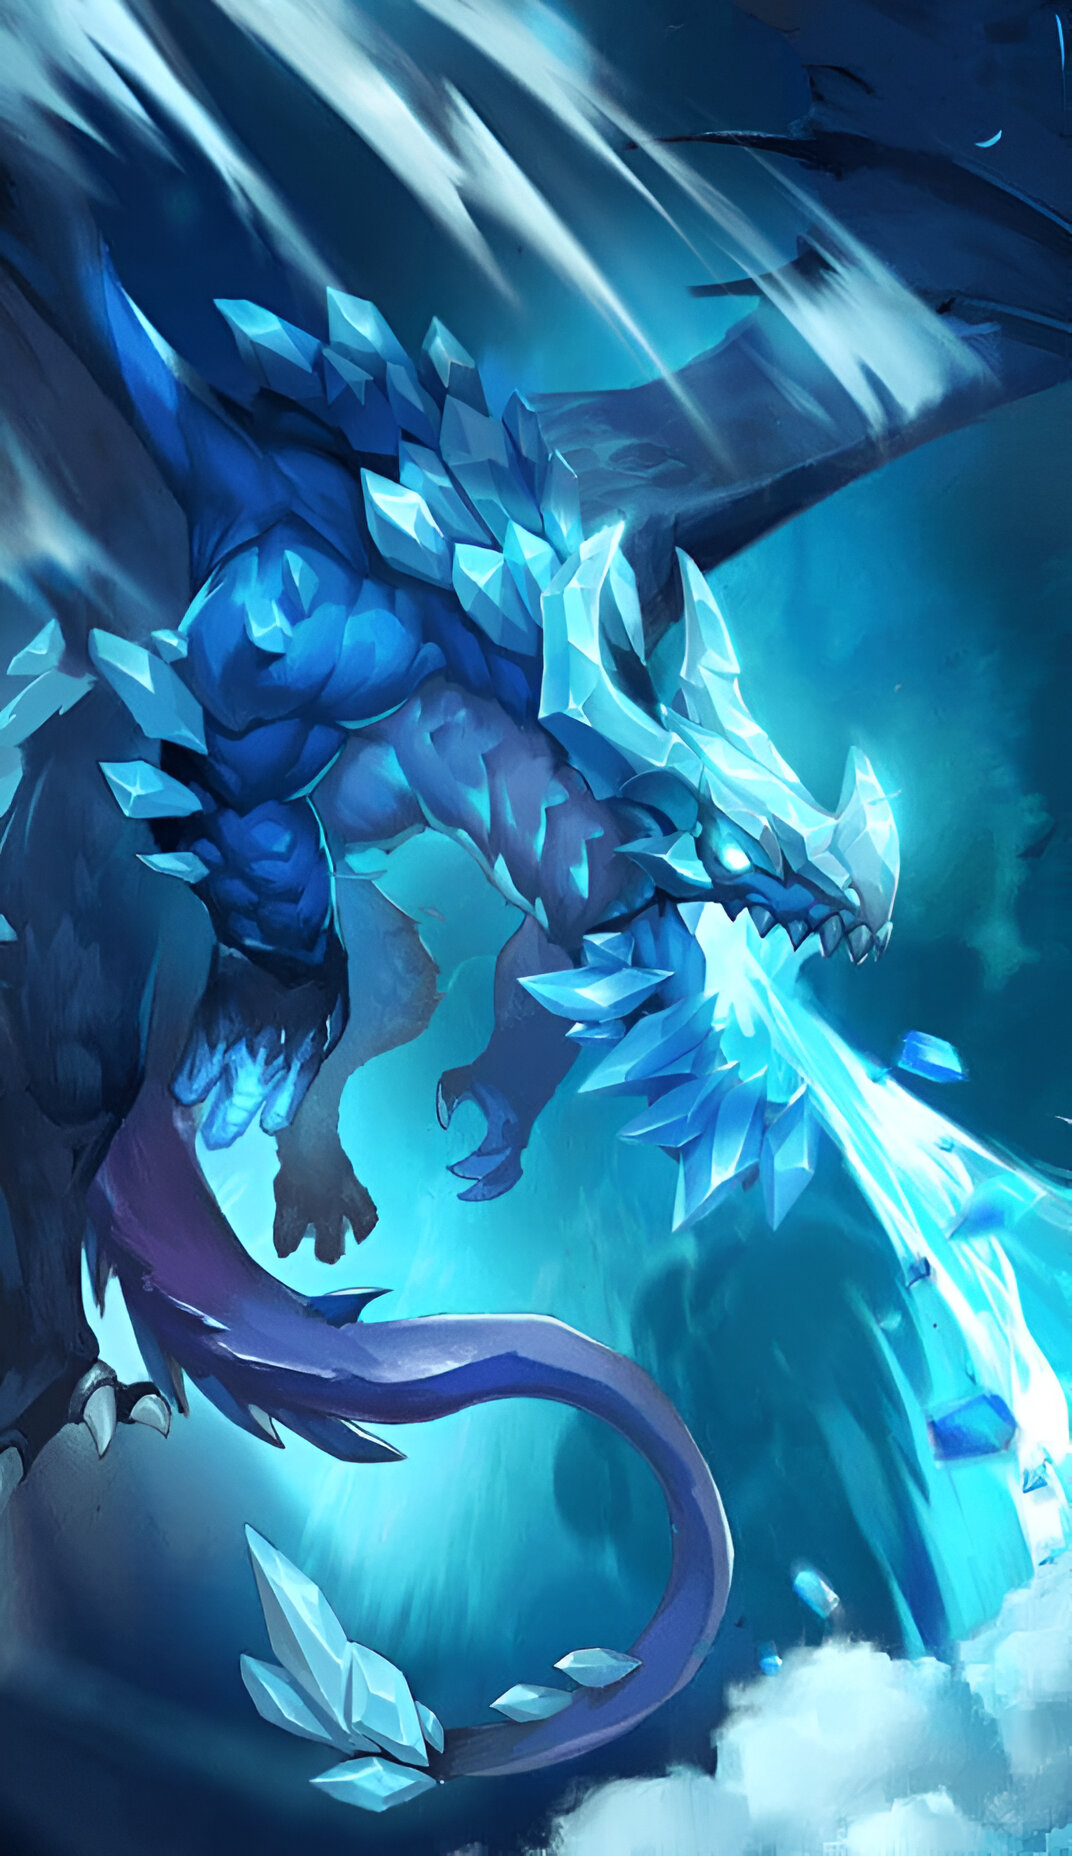

In [ ]:
import math

img = training_dataset[10]["img"]
card = training_dataset[10]

import requests
from PIL import Image
from io import BytesIO

response = requests.get(img)
image = Image.open(BytesIO(response.content))
display(image)

# alpha = math.sqrt(image.width * image.height / 500000)
# print(image.resize(image.width * alpha, image.height * alpha).size)

# print(autofill_from_card(card, img), end="\n")

# Cleaning

In [ ]:
import time
import gc

def clear():
  if "inputs" in globals():
    del globals()["inputs"]
  if "model" in globals():
    del globals()["model"]
  if "processor" in globals():
    del globals()["processor"]
  if "trainer" in globals():
    del globals()["trainer"]
  if "bnb_config" in globals():
    del globals()["bnb_config"]

  time.sleep(2)
  gc.collect()
  time.sleep(2)
  torch.cuda.empty_cache()
  torch.cuda.synchronize()
  time.sleep(2)
  gc.collect()
  time.sleep(2)

  print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
  print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

In [ ]:
from transformers import BitsAndBytesConfig
from peft import LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
)

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=16,
    bias="none",
    target_modules=['q_proj', 'v_proj'],
    task_type="CAUSAL_LM",
)

# Training Only

In [ ]:
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
  )

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
# model.config.label_names= ['labels']

In [ ]:
"""from trl import SFTConfig

training_args = SFTConfig(
    output_dir="pixtral-12b-casters",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    lr_scheduler_type="constant",
    save_steps=20,
    warmup_ratio=0.03,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.1,
    max_grad_norm=0.5,
    bf16=True,
    tf32=True,
    use_liger=True,
    push_to_hub=True,
    report_to="wandb",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

training_args.remove_unused_columns = False"""

In [ ]:
training_args = {
    "output_dir": "pixtral-12b-casters",
    "repo-id": "pixtral-12b-casters",
    "num_train_epochs": 3,
    "per_device_batch_size": 2,
    "lr_scheduler_type": "constant",
    "warmup_ratio": 0.1,
    "gradient_checkpointing": True,
    "gradient_checkpointing_kwargs": {"use_reentant": True},
    "dataset_kwargs": {"skip_prepare_dataset"},
    "dataset_text_fields": "",
    "optim": "adamw",
    "logging_steps": 10,
    "weight_decay": 0.1,
    "max_grad_norm": 0.5,
    "save_steps": 20,
    "gradient_checkpointing_steps": 3,
    "fp16": True,
    "tf32": False,
    "learning_rate": 2e-4,
    "gradient_accumulation_steps": 3,
    "push_to_hub": True,
}

In [ ]:
import wandb

wandb.login(key=WANDB_API_KEY)

wandb.init(
    project="tcg-fm",
    name="pixtral-12b-casters",
    config=training_args,
)

In [ ]:
import torch
import math
import wandb
from torch.utils.data import DataLoader
from transformers import get_scheduler
from accelerate import Accelerator
from peft import get_peft_model
import torch.optim as optim

# Initialize dataloader
dataloader = DataLoader(training_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)

# Initialize optimizer
if training_args["optim"] == "adamw":
    optimizer = optim.AdamW(model.parameters(), lr=training_args["learning_rate"], weight_decay=training_args["weight_decay"])
else:
    raise NotImplementedError("Only 'adamw' is implemented.")

# Compute training steps
num_training_steps = len(dataloader) * training_args["num_train_epochs"] / training_args["gradient_accumulation_steps"]
num_warmup_steps = math.ceil(num_training_steps * training_args["warmup_ratio"])

# Learning rate scheduler
lr_scheduler = get_scheduler(
    training_args["lr_scheduler_type"],
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Enable TF32 if specified
if training_args.get("tf32", False):
    torch.backends.cuda.matmul.allow_tf32 = True

# Enable gradient checkpointing if specified
if training_args.get("gradient_checkpointing", False):
    model.config.use_cache = False  # Disable caching when using gradient checkpointing
    model.gradient_checkpointing_enable()

# Initialize Accelerator
accelerator = Accelerator(mixed_precision="bf16" if training_args.get("bf16", False) else "fp16")

model = get_peft_model(model, lora_config)
model.enable_input_require_grads()

# Prepare model, optimizer, dataloader, and scheduler
model, optimizer, dataloader, lr_scheduler = accelerator.prepare(model, optimizer, dataloader, lr_scheduler)

# Training loop
model.train()
global_steps = 0
gradient_accumulation_steps = training_args["gradient_accumulation_steps"]

for epoch in range(training_args["num_train_epochs"]):
    for step, batch in enumerate(dataloader):
        outputs = model(**batch)
        loss = outputs.loss / gradient_accumulation_steps
        accelerator.backward(loss)

        if (step + 1) % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), training_args["max_grad_norm"])
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_steps += 1

            if global_steps % training_args["logging_steps"] == 0:
                accelerator.print(f"Epoch {epoch}, Step {global_steps}: Loss = {loss.item() * gradient_accumulation_steps:.4f}")
                wandb.log({"loss": loss.item() * gradient_accumulation_steps, "step": global_steps, "epoch": epoch})

            if global_steps % training_args["save_steps"] == 0:
                accelerator.save_state(training_args["output_dir"])

        # Free memory
        del loss, outputs
        torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import HFApi

api = HFApi()

# Push model to Hugging Face Hub if enabled
if training_args["push_to_hub"]:
    output_dir = training_args["output_dir"]
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)
    repo_id=training_args["repo_id"]
    api.upload_folder(folder_path=output_dir, repo_id=repo_id, commit_message="initial commit")

In [ ]:
"""from trl import SFTTrainer

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=training_dataset,
    peft_config=lora_config,
    data_collator=collator_fn
)

trainer.train()"""

In [ ]:
"""trainer.save_model(training_args.output_dir)
clear()"""